<h1 align="center"><b>Applied Data Science Capstone Poject by</b></h1>
<h2 align="center"><b>IBM / Coursera</b></h1>
<h2 align=center>Finding suitable locations to open a Gym in Athens, Greece</h2>
<h2 align=center>Vasilis Kokkinos (June 2019)</h2>

## Table of contents
* [Introduction / Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

 ## 1. Introduction / Business Problem<a name="introduction"></a>

The aim of this project is to find suitable locations to open a __gym__ in the __Athens__ greater metropolitan area [Athens and its suburbs], Greece.  

The first requirement is that the new gym should be easily accessible by its prospective customers and more specifically it should be located __near a metro station__. The __number of gyms already existing in an area__ should also be considered so that fierce competition be avoided if possible.

Apart from the obvious intended stakeholders, entrepreneurs looking to start a gym business, similar methodology could be used for other specific types of businesses. It can serve as an initial starting point of locations to consider to start their business.

For the project objectives to be achieved, python geolocation libraries will be used, along with the Foursquare API. Also, in order to create clusters of similar candidate locations, the K-Means machine learning clustering algorithm will be used.

 ## 2. Data<a name="data"></a>

The necessary data for this project, based on the above stated requirements, are:

* The metro stations in the Athens greater metropolitan area
* Number of existing gyms near each station
* In addition, the distance to the nearest gym for every metro station will be used

In order to obtain the data, a combination of the __geopy__ Python library and the __Foursquare API__ will be used:

__1.__ ‘Syntagma square’ will be considered as the center of Athens. It is indeed one of the most central location in the city. I will obtain its geospatial coordinates using the geopy library

__2.__ Having the coordinates of the ‘center’ of Athens, the Foursquare API will be used to retrieve data for all the metro stations in Athens greater area in a radius of 15 km

__3.__ To find the existing gyms near the metro stations, the Foursquare API will again be used for every station. I will obtain data for all the gyms located in a radius of 750 meters of every metro station

Using the collected data, I will calculate the number of existing gyms near each station. __I will also be able to determine the minimum distance to a gym for every metro station__ from the 3rd step of the above process. This minimum distance to every metro station from a gym, along with the number of already existing gyms near the station will be used as input to K-Means clustering algorithm to obtain the clusters of areas (metro stations).

 ## 3. Methodology<a name="methodology"></a>

The objective of this project is to obtain information about metro stations in the greater metropolitan Athens area with potential for opening a gym, and having as criteria:
* Low number of already existing gyms
* Minimum distance of existing gyms to its nearby station

The steps I will follow to identify potential areas (metro stations) are:
1.	Consider ‘Syntagma square’ as the ‘center’ of Athens.
2.	Based on the coordinates of Syntagma Square, I will obtain information about metro stations in a radius of 15 km using the Foursquare API.
At this stage I will remove from the above dataset points that although they are identified as ‘Metro stations’ by the Foursquare API, they are only used as depots or maintenance gathering  for the metro carriages.
3.	After the collection of metro stations information, I will again use the Foursquare API to locate all the existing gyms in a radius of 750 meters from each station. At this stage I will only keep as my data set the results that correspond only to __‘Gym / Fitness Center’__ and __‘Gym’__ subcategories. I will remove the rest of the subcategories such as ‘Dance Studio’, ‘Yoga Studio’, ‘Martial Arts Dojo’ etc.
I will ignore for the purpose of clusttering any metro stations that based on the results of the Foursquare API don’t have any existing gyms in their vicinity. For those, there can either be no existing data in the Foursquare database, or indeed there no existing gyms near the corresponding station.
The data set will also contain the distance of each gym to the corresponding station.
4.	Having the information about gyms around metro stations, I will calculate the number of existing gyms near each station as well as the minimum distance from each station to a gym using available python statistical functions.
5.	The data will be normalized so that both factors (minimum distance, number of existing gyms) will have equal weight when they will be used by a machine learning method.
6.	The K-Means Machine Learning clustering algorithm will be used to divide the stations and gyms data set into clusters of similar locations.
The elbow method will be used to find the most suitable number of clusters.

#### Install the necessary libraries

In [2]:
!conda install -c conda-forge geopy --yes

Solving environment: ...working... done

# All requested packages already installed.



In [3]:
!conda install -c conda-forge folium --yes

Solving environment: ...working... done

# All requested packages already installed.



#### Import libraries

In [4]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import pandas as pd
# Set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

from pandas.io.json import json_normalize

import folium # map rendering library

import requests

import numpy as np

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.pyplot import subplots

from sklearn import preprocessing

print('Libraries imported.')

Libraries imported.


### Data Acquisition, Cleaning and Transformation

#### Get the geospatial coordinates of 'Syntagma Square'

In [5]:
address = 'Syntagma Square, Greece'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Syntagma Metro Station are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Syntagma Metro Station are 37.9755667, 23.7347088404687.


In [6]:
string = str(latitude) + ', ' +str(longitude)
address = geolocator.reverse(string, language='en')
address

Location(1, Φιλελλήνων, Plaka, Kolonaki, Athens, Municipality of Athens, Regional Unit of Central Athens, Region of Attica, Attica, 105 57, Greece, (37.9747604, 23.7342102, 0.0))

Let's show 'Syntagma Square' on a map

In [7]:
map_syntagma = folium.Map(location=[latitude, longitude], zoom_start=18)
folium.Marker([latitude, longitude], popup='Syntagma Square').add_to(map_syntagma)
map_syntagma

The map will not display on github, so I added it as an html image in a markdown cell.

<img src="syntagma_map.png">

In [23]:
# The code was removed by Watson Studio for sharing.

Category id for metro stations: __4bf58dd8d48988d1fd931735__

Source: https://developer.foursquare.com/docs/resources/categories

#### Get the metro stations in Athens in radius of 15 km around Syntagma

In [8]:
radius = 15000
VERSION = '20190630' # Foursquare API version
LIMIT = 200
category_id = '4bf58dd8d48988d1fd931735' # Metro Stations

In [9]:
url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    category_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude,
    longitude, 
    radius,
    LIMIT
)

In [10]:
# stations_list = results['response']['groups'][0]['items']
stations_list = requests.get(url).json()['response']['groups'][0]['items']
stations_init_df = json_normalize(stations_list)

stations_init_df.head(2)

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",e-0-4b963ad8f964a5208cc134e3-0,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",4b963ad8f964a5208cc134e3,Πλατεία Συντάγματος,GR,Αθήνα,Ελλάδα,NaN,63,"[Πλατεία Συντάγματος, 105 63 Αθήνα, Αττική, Ελλάδα]","[{'label': 'display', 'lat': 37.97523509105853, 'lng': 23.735297943276063}]",37.975235,23.735298,NaN,105 63,Αττική,Syntagma Metro Station (Σταθμός Μετρό Σύνταγμα),0,[]
1,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",e-0-4c8cd57655fba093d8c162ab-1,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",4c8cd57655fba093d8c162ab,Στρατηγού Μακρυγιάννη,GR,Αθήνα,Ελλάδα,Αθανάσιου Διάκου,879,"[Στρατηγού Μακρυγιάννη (Αθανάσιου Διάκου), 117 42 Αθήνα, Αττική, Ελλάδα]","[{'label': 'display', 'lat': 37.968515728164675, 'lng': 23.73019520865571}]",37.968516,23.730195,NaN,117 42,Αττική,Akropoli Metro Station (Σταθμός Μετρό Ακρόπολη),0,[]


Extract station information

In [11]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance', 'venue.location.postalCode']
stations_filtered_df = stations_init_df.loc[:, filtered_columns]

# filter the category for each row
stations_filtered_df['venue_type'] = stations_init_df['venue.categories'].apply(lambda x: dict(x[0])['name'])

# clean columns
stations_filtered_df.columns = [col.split('.')[-1] for col in stations_filtered_df.columns]

stations_df = stations_filtered_df[stations_filtered_df['venue_type'] == 'Metro Station']
stations_df = stations_df.drop('categories', axis=1)
stations_df.head()

,name,lat,lng,distance,postalCode,venue_type
0,Syntagma Metro Station (Σταθμός Μετρό Σύνταγμα),37.975235,23.735298,63,105 63,Metro Station
1,Akropoli Metro Station (Σταθμός Μετρό Ακρόπολη),37.968516,23.730195,879,117 42,Metro Station
2,Evangelismos Metro Station (Σταθμός Μετρό Ευαγγελισμός),37.976173,23.747163,1094,106 76,Metro Station
3,Monastiraki Metro Station (Σταθμός Μετρό Μοναστηράκι),37.976067,23.725752,787,105 54,Metro Station
4,Panepistimio Metro Station (Σταθμός Μετρό Πανεπιστήμιο),37.980004,23.732354,535,105 64,Metro Station


In [12]:
stations_df.shape

(63, 6)

Check that all the rows indeed represent a metro station

In [13]:
stations_df[stations_df['name'].str.find('Station') == -1]

,name,lat,lng,distance,postalCode,venue_type
40,Αμαξοστάσιο Μετρό Ελαιώνα,37.986554,23.686795,4378,NaN,Metro Station
61,Αμαξοστάσιο Μετρό Δουκίσης Πλακεντίας,38.022099,23.835587,10253,NaN,Metro Station


Indeed the above two rows are 'parking' places for trains. They need to be removed from the dataframe

In [14]:
# Keep only the stations that their name contains 'Station' 
stations_df = stations_df[stations_df['name'].str.contains('Station')]
stations_df.shape

(61, 6)

Separate the greek and english name into two columns

In [15]:
stations_df['name GR'] = stations_df['name'].apply(lambda x: x.split('(')[1].replace(')', '').strip())
stations_df['name'] = stations_df['name'].apply(lambda x: x.split('(')[0]).str.strip()

fixed_columns = [stations_df.columns[0]] + [stations_df.columns[-1]] + list(stations_df.columns[1:-1])
stations_df = stations_df[fixed_columns]
stations_df.head()

,name,name GR,lat,lng,distance,postalCode,venue_type
0,Syntagma Metro Station,Σταθμός Μετρό Σύνταγμα,37.975235,23.735298,63,105 63,Metro Station
1,Akropoli Metro Station,Σταθμός Μετρό Ακρόπολη,37.968516,23.730195,879,117 42,Metro Station
2,Evangelismos Metro Station,Σταθμός Μετρό Ευαγγελισμός,37.976173,23.747163,1094,106 76,Metro Station
3,Monastiraki Metro Station,Σταθμός Μετρό Μοναστηράκι,37.976067,23.725752,787,105 54,Metro Station
4,Panepistimio Metro Station,Σταθμός Μετρό Πανεπιστήμιο,37.980004,23.732354,535,105 64,Metro Station


Some final changes

In [16]:
stations_df.rename(columns={'name': 'station',
                            'name GR': 'station GR',
                            'distance': 'Distance from Center',
                            'postalCode': 'Postal Code',
                            'venue_type': 'Venue Type'},
                   inplace=True)

stations_df.reset_index(drop=True, inplace=True)

print(stations_df.info())
stations_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 7 columns):
station                 61 non-null object
station GR              61 non-null object
lat                     61 non-null float64
lng                     61 non-null float64
Distance from Center    61 non-null int64
Postal Code             39 non-null object
Venue Type              61 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 3.4+ KB
None


,station,station GR,lat,lng,Distance from Center,Postal Code,Venue Type
0,Syntagma Metro Station,Σταθμός Μετρό Σύνταγμα,37.975235,23.735298,63,105 63,Metro Station
1,Akropoli Metro Station,Σταθμός Μετρό Ακρόπολη,37.968516,23.730195,879,117 42,Metro Station
2,Evangelismos Metro Station,Σταθμός Μετρό Ευαγγελισμός,37.976173,23.747163,1094,106 76,Metro Station
3,Monastiraki Metro Station,Σταθμός Μετρό Μοναστηράκι,37.976067,23.725752,787,105 54,Metro Station
4,Panepistimio Metro Station,Σταθμός Μετρό Πανεπιστήμιο,37.980004,23.732354,535,105 64,Metro Station


Visualize the metro stations on a map of Athens

In [18]:
# create map of Athens using latitude and longitude values
map_athens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, station in zip(stations_df['lat'],
                          stations_df['lng'],
                          stations_df['station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_athens)
    
map_athens

The map will not display on github, so I added it as an html image in a markdown cell.

<img src="stations_map.png">

#### Get the gyms near the stations

Category id for metro stations: __4bf58dd8d48988d175941735__

Source: https://developer.foursquare.com/docs/resources/categories

Function to create a dataframe with the results gathered from Foursquare API on a specific category

In [19]:
def getNearbyGyms(categoryId, stations, latitudes, longitudes, radius=750):
    
    print('Findind gyms near Athens metro stations, please wait...\n')
    
    gyms_list=[]
    for station, lat, lng in zip(stations, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            categoryId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby gym
        gyms_list.append([(
            station,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']
        ) for v in results])

    nearby_gyms_df = pd.DataFrame([item for venue_list in gyms_list for item in venue_list])
    nearby_gyms_df.columns = [
                  'station',
                  'lat',
                  'lng',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Distance from Station',
                  'Venue Category']
    print('Finished')
    return(nearby_gyms_df)

Use the function to gather information about existing gyms in a radius of 750m around each metro station in Athens

In [20]:
categoryId = '4bf58dd8d48988d175941735' # Gym / Fitness Center
gyms_venues_df = getNearbyGyms(categoryId, stations=stations_df['station'], latitudes=stations_df['lat'], longitudes=stations_df['lng'])

Findind gyms near Athens metro stations, please wait...

Finished


In [21]:
gyms_venues_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,Syntagma Metro Station,37.975235,23.735298,GB Spa,37.976240,23.735361,112,Gym / Fitness Center
1,Syntagma Metro Station,37.975235,23.735298,Holmes Place Athens,37.976774,23.734384,189,Gym
2,Syntagma Metro Station,37.975235,23.735298,Athlesis Gym,37.978945,23.739857,574,Gym / Fitness Center
3,Syntagma Metro Station,37.975235,23.735298,The Fitting Room,37.976295,23.742791,668,Gym / Fitness Center
4,Syntagma Metro Station,37.975235,23.735298,Holmes Place,37.977147,23.734305,229,Gym / Fitness Center


Let's check the categories of venues that were returned for each neighborhood

In [22]:
gyms_venues_df.groupby(['Venue Category']).count()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Athletics & Sports,2,2,2,2,2,2,2
Basketball Court,4,4,4,4,4,4,4
Boxing Gym,2,2,2,2,2,2,2
Climbing Gym,3,3,3,3,3,3,3
Cycle Studio,1,1,1,1,1,1,1
Dance Studio,7,7,7,7,7,7,7
Gym,156,156,156,156,156,156,156
Gym / Fitness Center,166,166,166,166,166,166,166
Gym Pool,3,3,3,3,3,3,3


#### We will only keep the two categories [Gym, Gym / Fitness Center]

In [23]:
gyms_venues_df = gyms_venues_df[gyms_venues_df['Venue Category'].isin(['Gym', 'Gym / Fitness Center'])]
gyms_venues_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,Syntagma Metro Station,37.975235,23.735298,GB Spa,37.976240,23.735361,112,Gym / Fitness Center
1,Syntagma Metro Station,37.975235,23.735298,Holmes Place Athens,37.976774,23.734384,189,Gym
2,Syntagma Metro Station,37.975235,23.735298,Athlesis Gym,37.978945,23.739857,574,Gym / Fitness Center
3,Syntagma Metro Station,37.975235,23.735298,The Fitting Room,37.976295,23.742791,668,Gym / Fitness Center
4,Syntagma Metro Station,37.975235,23.735298,Holmes Place,37.977147,23.734305,229,Gym / Fitness Center


Make sure that the not needed venues were removed

In [24]:
gyms_venues_df.groupby(['Venue Category']).count().head(10)

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Gym,156,156,156,156,156,156,156
Gym / Fitness Center,166,166,166,166,166,166,166


#### Add distance from each metro station to the nearest gym and number of existing gyms in its vicinity

Add to the data frame the minimum distance of every station to the gyms in its vicinity

In [25]:
gyms_venues_min_df = pd.merge(gyms_venues_df,
                              pd.DataFrame(gyms_venues_df.groupby('station')['Distance from Station'].min()),
                              on='station', how='inner')

In [26]:
gyms_venues_min_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y
0,Syntagma Metro Station,37.975235,23.735298,GB Spa,37.976240,23.735361,112,Gym / Fitness Center,112
1,Syntagma Metro Station,37.975235,23.735298,Holmes Place Athens,37.976774,23.734384,189,Gym,112
2,Syntagma Metro Station,37.975235,23.735298,Athlesis Gym,37.978945,23.739857,574,Gym / Fitness Center,112
3,Syntagma Metro Station,37.975235,23.735298,The Fitting Room,37.976295,23.742791,668,Gym / Fitness Center,112
4,Syntagma Metro Station,37.975235,23.735298,Holmes Place,37.977147,23.734305,229,Gym / Fitness Center,112


Add the number of already existing gyms in the vicinity of each station

In [27]:
gyms_venues_min_count_df = pd.merge(gyms_venues_min_df,
                           pd.DataFrame(gyms_venues_min_df.groupby(['station']).count())['lat'],
                           on='station', how='inner')

In [28]:
gyms_venues_min_count_df.head()

,station,lat_x,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y,lat_y
0,Syntagma Metro Station,37.975235,23.735298,GB Spa,37.976240,23.735361,112,Gym / Fitness Center,112,13
1,Syntagma Metro Station,37.975235,23.735298,Holmes Place Athens,37.976774,23.734384,189,Gym,112,13
2,Syntagma Metro Station,37.975235,23.735298,Athlesis Gym,37.978945,23.739857,574,Gym / Fitness Center,112,13
3,Syntagma Metro Station,37.975235,23.735298,The Fitting Room,37.976295,23.742791,668,Gym / Fitness Center,112,13
4,Syntagma Metro Station,37.975235,23.735298,Holmes Place,37.977147,23.734305,229,Gym / Fitness Center,112,13


Give appropriate names to the dataframe columns

In [29]:
gyms_df = gyms_venues_min_count_df.rename(columns={'lat_x': 'lat', 'Distance from Station_x': 'Distance from Station',
                                                   'Distance from Station_y': 'Min Distance from Station',
                                                   'lat_y': 'Gym Count'})
gyms_df.head(15)

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category,Min Distance from Station,Gym Count
0,Syntagma Metro Station,37.975235,23.735298,GB Spa,37.976240,23.735361,112,Gym / Fitness Center,112,13
1,Syntagma Metro Station,37.975235,23.735298,Holmes Place Athens,37.976774,23.734384,189,Gym,112,13
2,Syntagma Metro Station,37.975235,23.735298,Athlesis Gym,37.978945,23.739857,574,Gym / Fitness Center,112,13
3,Syntagma Metro Station,37.975235,23.735298,The Fitting Room,37.976295,23.742791,668,Gym / Fitness Center,112,13
4,Syntagma Metro Station,37.975235,23.735298,Holmes Place,37.977147,23.734305,229,Gym / Fitness Center,112,13
5,Syntagma Metro Station,37.975235,23.735298,Personal Alive Gym,37.976590,23.739395,389,Gym / Fitness Center,112,13
6,Syntagma Metro Station,37.975235,23.735298,Pol Bitsakis Personal Training Center,37.975364,23.733791,133,Gym,112,13
7,Syntagma Metro Station,37.975235,23.735298,Slim Figure Studio Pilates,37.979138,23.736875,455,Gym / Fitness Center,112,13
8,Syntagma Metro Station,37.975235,23.735298,LM Γυμναστήρια,37.976835,23.740708,507,Gym / Fitness Center,112,13
9,Syntagma Metro Station,37.975235,23.735298,Air Power Fitness Club,37.979704,23.738001,551,Gym / Fitness Center,112,13


We will keep only the necessary columns

In [30]:
gyms_df = gyms_df[['station', 'lat', 'lng', 'Min Distance from Station', 'Gym Count']].drop_duplicates()

In [31]:
gyms_df.head(10)

,station,lat,lng,Min Distance from Station,Gym Count
0,Syntagma Metro Station,37.975235,23.735298,112,13
13,Akropoli Metro Station,37.968516,23.730195,202,5
18,Evangelismos Metro Station,37.976173,23.747163,251,16
34,Monastiraki Metro Station,37.976067,23.725752,709,2
36,Panepistimio Metro Station,37.980004,23.732354,328,13
49,Omonia Metro Station,37.984602,23.726186,424,4
53,Sygrou-Fix Metro Station,37.964919,23.726618,185,8
61,Panormou Metro Station,37.993298,23.764135,195,11
72,Monastiraki ISAP Station,37.976044,23.725204,705,1
73,Omonoia ISAP Station,37.984100,23.728071,262,5


In our initial stations dataframe, after the two non-real metro stations were removed, we had __61 rows__. Check how many metro stations were returned from the Foursquare API with already existing gyms

In [32]:
gyms_df.shape

(59, 5)

#### It seems that __we are missing two stations from the original 61__. They probably did not have any gyms in their vicinity or there are no data available for these stations. We need to keep them in mind for any future further investigation. For now these two stations will be ignored

We will merge the initial __stations_df dataframe__ with the previously created __gyms_df__ and assign 10000 to 'Min Distance from Station' and 0 to 'Gym Count'

In [33]:
missing_stations_df = pd.merge(stations_df[['station', 'lat', 'lng']], gyms_df,
                                    on='station', how='left')
missing_stations_df[missing_stations_df['Gym Count'].isnull()]

,station,lat_x,lng_x,lat_y,lng_y,Min Distance from Station,Gym Count
59,Paiania-Kantza Metro Station,37.984707,23.870084,NaN,NaN,NaN,NaN
60,Kifisia ISAP Station,38.071627,23.797488,NaN,NaN,NaN,NaN


So the two metro stations for which no data were returned from the Foursquare API are:
* Paiania-Kantza Metro Station
* Kifisia ISAP Station

Now is a good time to make a copy of the dataframe that was created

In [34]:
stations_gyms_grouped_df = gyms_df.copy()

In [35]:
stations_gyms_grouped_df.shape

(59, 5)

In [36]:
stations_gyms_grouped_df.head()

,station,lat,lng,Min Distance from Station,Gym Count
0,Syntagma Metro Station,37.975235,23.735298,112,13
13,Akropoli Metro Station,37.968516,23.730195,202,5
18,Evangelismos Metro Station,37.976173,23.747163,251,16
34,Monastiraki Metro Station,37.976067,23.725752,709,2
36,Panepistimio Metro Station,37.980004,23.732354,328,13


## Normalize Data [Min Distance from Station, Gym Count]

Data Standardization give data zero mean and unit variance

In [37]:
print('All stations mean distance from any gym: ', stations_gyms_grouped_df['Min Distance from Station'].mean())
print('All stations maximum distance from any gym: ',stations_gyms_grouped_df['Min Distance from Station'].max())
print('All stations minimum distance from any gym: ', stations_gyms_grouped_df['Min Distance from Station'].min())
print('All stations mean of number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].mean())
print('All stations maximum number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].max())
print('All stations minimum number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].min())

All stations mean distance from any gym:  279.9491525423729
All stations maximum distance from any gym:  729
All stations minimum distance from any gym:  17
All stations mean of number of existing gyms:  5.4576271186440675
All stations maximum number of existing gyms:  16
All stations minimum number of existing gyms:  1


In [38]:
stations_gyms_grouped_df['Norm Min Distance from Station'] = (stations_gyms_grouped_df['Min Distance from Station'] - \
                                                              stations_gyms_grouped_df['Min Distance from Station'].mean()) / \
                                                             (stations_gyms_grouped_df['Min Distance from Station'].max() - \
                                                              stations_gyms_grouped_df['Min Distance from Station'].min())
stations_gyms_grouped_df['Norm Gym Count'] = (stations_gyms_grouped_df['Gym Count'] - stations_gyms_grouped_df['Gym Count'].mean()) / \
                                             (stations_gyms_grouped_df['Gym Count'].max() - stations_gyms_grouped_df['Gym Count'].min())

In [39]:
stations_gyms_grouped_df['Gym Count'] = stations_gyms_grouped_df['Gym Count'].astype(int)

In [40]:
stations_gyms_grouped_df.reset_index(drop=True, inplace=True)

In [41]:
stations_gyms_grouped_df.head(10)

,station,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,Syntagma Metro Station,37.975235,23.735298,112,13,-0.235884,0.502825
1,Akropoli Metro Station,37.968516,23.730195,202,5,-0.109479,-0.030508
2,Evangelismos Metro Station,37.976173,23.747163,251,16,-0.040659,0.702825
3,Monastiraki Metro Station,37.976067,23.725752,709,2,0.602600,-0.230508
4,Panepistimio Metro Station,37.980004,23.732354,328,13,0.067487,0.502825
5,Omonia Metro Station,37.984602,23.726186,424,4,0.202319,-0.097175
6,Sygrou-Fix Metro Station,37.964919,23.726618,185,8,-0.133356,0.169492
7,Panormou Metro Station,37.993298,23.764135,195,11,-0.119311,0.369492
8,Monastiraki ISAP Station,37.976044,23.725204,705,1,0.596982,-0.297175
9,Omonoia ISAP Station,37.984100,23.728071,262,5,-0.025209,-0.030508


## K-Means Clustering

#### Prepare the dataframe to be used in K-Means algorithm

In [42]:
gyms_clustering_df = stations_gyms_grouped_df.drop(['station', 'lat', 'lng', 'Min Distance from Station', 'Gym Count'], 1)

In [43]:
gyms_clustering_df.head()

,Norm Min Distance from Station,Norm Gym Count
0,-0.235884,0.502825
1,-0.109479,-0.030508
2,-0.040659,0.702825
3,0.602600,-0.230508
4,0.067487,0.502825


#### Cluster Locations (Metro stations) in Athens (K-Means Clustering)

The KMeans class has many parameters that can be used, but we will be using these three:
<ul>
    <li> <b>init</b>: Initialization method of the centroids. </li>
    <ul>
        <li> Value will be: "k-means++" </li>
        <li> k-means++: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.</li>
    </ul>
    <li> <b>n_clusters</b>: The number of clusters to form as well as the number of centroids to generate. </li>
    <ul> <li> Value will be: 4 (since we have 4 centers)</li> </ul>
    <li> <b>n_init</b>: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia. </li>
    <ul> <li> Value will be: 12 </li> </ul>
</ul>

#### Use the Elbow method to find the best k for clustering

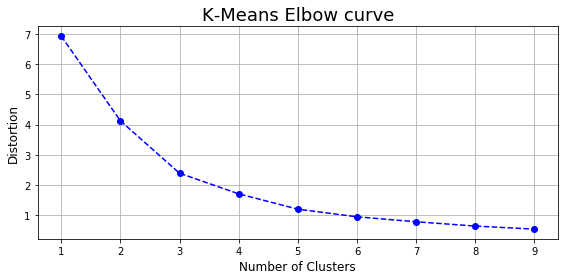

In [44]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(1, 10):
    kmeans = KMeans(init="k-means++", n_clusters=k, random_state=0, n_init = 12, max_iter=300, tol=0.00001)
    kmeans.fit(gyms_clustering_df)
    distorsions.append(kmeans.inertia_)

fig, ax = subplots(figsize=(8, 4))
ax.plot(range(1, 10), distorsions, '--bo')
ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_ylabel('Distortion', fontsize=12)
plt.grid(True)
plt.title('K-Means Elbow curve', fontsize='18')
plt.tight_layout()
plt.show()

The elbow graph, although not very steep, presents an elbow point at 3 number of clusters.

#### Run k-means to cluster the station areas to 3 clusters 

In [45]:
# venues_grouped_clustering_df = venues_grouped_df.drop('station', 1)
kmeans = KMeans(init="k-means++", n_clusters=3, random_state=0, n_init = 12, max_iter=300, tol=0.0001)
kmeans.fit(gyms_clustering_df)

kmeans.labels_

array([1, 0, 1, 2, 1, 2, 1, 1, 2, 0, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 1, 0,
       0, 0, 2, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2])

## 4. K-Means Clustering Results<a name="results"></a>

Create a new dataframe that includes the resulted clusters and relevant metro station information

In [46]:
# add clustering labels
stations_gyms_grouped_df.insert(1, 'Cluster Label', kmeans.labels_)

In [47]:
stations_gyms_grouped_df.head()

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,Syntagma Metro Station,1,37.975235,23.735298,112,13,-0.235884,0.502825
1,Akropoli Metro Station,0,37.968516,23.730195,202,5,-0.109479,-0.030508
2,Evangelismos Metro Station,1,37.976173,23.747163,251,16,-0.040659,0.702825
3,Monastiraki Metro Station,2,37.976067,23.725752,709,2,0.602600,-0.230508
4,Panepistimio Metro Station,1,37.980004,23.732354,328,13,0.067487,0.502825


Visualize the metro stations clusters on a map of Athens

In [48]:
cluster_colors = ['orange', 'red', 'blue'] #, 'green', 'purple', 'pink', 'purple', 'lightblue', 'yellow']

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

markers_colors = []
for lat, lon, poi, cluster in zip(stations_gyms_grouped_df['lat'], stations_gyms_grouped_df['lng'], 
                                  stations_gyms_grouped_df['station'], stations_gyms_grouped_df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster_colors[cluster],
        fill=True,
        fill_color=cluster_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The map will not display on github, so I added it as an html image in a markdown cell.

<img src="clusters_map.png">

Now visualize the (normalized) clusters distribution on a scatter plot along with their final corresponding centroids

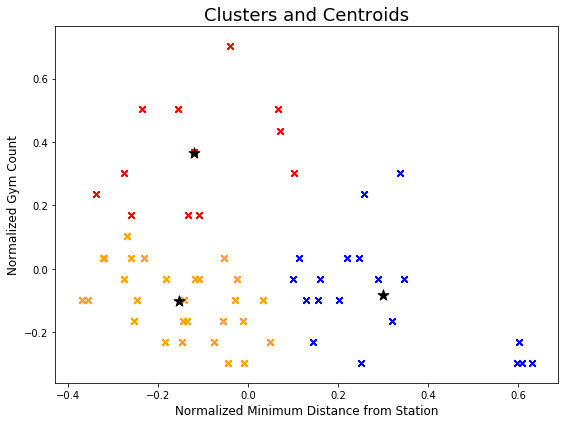

In [49]:
fig, ax = subplots(figsize=(8, 6))
for label in kmeans.labels_:
    plt.scatter(stations_gyms_grouped_df[stations_gyms_grouped_df['Cluster Label'] == label]['Norm Min Distance from Station'],
                stations_gyms_grouped_df[stations_gyms_grouped_df['Cluster Label'] == label]['Norm Gym Count'],
                marker='x', color=cluster_colors[label])
for centroid in kmeans.cluster_centers_:
#     print(centroid)
    plt.scatter(centroid[0], centroid[1], s=130, marker="*", color='black')
ax.set_xlabel('Normalized Minimum Distance from Station', fontsize=12)
ax.set_ylabel('Normalized Gym Count', fontsize=12)
plt.title('Clusters and Centroids', fontsize='18')
plt.tight_layout()
plt.show()

#### Show the Metro stations that correspond to each cluster

#### Cluster 1 (__AVERAGE__ potential)

Although not a prohibitive metro station to open a gym in its vicinity, there is already a fair number of gyms in the area and the nearest one is not far from the metro station

In [50]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 0]

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
1,Akropoli Metro Station,0,37.968516,23.730195,202,5,-0.109479,-0.030508
9,Omonoia ISAP Station,0,37.984100,23.728071,262,5,-0.025209,-0.030508
11,Aghios Dimitrios Metro Station,0,37.940089,23.740915,183,3,-0.136165,-0.163842
12,Kerameikos Metro Station,0,37.978550,23.711564,52,6,-0.320153,0.036158
15,Attiki Metro Station,0,37.999452,23.722549,176,2,-0.145996,-0.230508
18,Neos Kosmos Metro Station,0,37.957934,23.727630,89,7,-0.268187,0.102825
19,Larisis Metro Station,0,37.991851,23.720942,242,6,-0.053299,0.036158
21,Petralona ISAP Station,0,37.968341,23.709012,315,2,0.049229,-0.230508
22,Egaleo Metro Station,0,37.991428,23.681813,115,6,-0.231670,0.036158
23,Attiki ISAP Station,0,37.999735,23.722709,148,2,-0.185322,-0.230508


#### Cluster 2 (__LOW__ potential])

There are already many existing gyms in the area and the nearest gym is in most cases in a relatively short distance from the station

In [51]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 1]

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,Syntagma Metro Station,1,37.975235,23.735298,112,13,-0.235884,0.502825
2,Evangelismos Metro Station,1,37.976173,23.747163,251,16,-0.040659,0.702825
4,Panepistimio Metro Station,1,37.980004,23.732354,328,13,0.067487,0.502825
6,Sygrou-Fix Metro Station,1,37.964919,23.726618,185,8,-0.133356,0.169492
7,Panormou Metro Station,1,37.993298,23.764135,195,11,-0.119311,0.369492
14,Megaro Moussikis Metro Station,1,37.979014,23.753173,95,8,-0.259760,0.169492
20,Ampelokipi Metro Station,1,37.987439,23.757075,169,13,-0.155827,0.502825
25,Tavros ISAP Station,1,37.962494,23.703367,330,12,0.070296,0.436158
28,Kallithea ISAP Station,1,37.960339,23.697373,39,9,-0.338412,0.236158
37,Peristeri Metro Station,1,38.012749,23.696161,202,8,-0.109479,0.169492


#### Cluster 3 (__HIGH__ potential)

There are not many already existing gyms in the area and the nearest gym is in most cases relatively not in a short distance to the metro station

In [52]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 2]

,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
3,Monastiraki Metro Station,2,37.976067,23.725752,709,2,0.602600,-0.230508
5,Omonia Metro Station,2,37.984602,23.726186,424,4,0.202319,-0.097175
8,Monastiraki ISAP Station,2,37.976044,23.725204,705,1,0.596982,-0.297175
10,Thisseio ISAP Station,2,37.976166,23.720449,459,1,0.251476,-0.297175
13,Metaxourghio Metro Station,2,37.985549,23.720734,394,5,0.160184,-0.030508
16,Aghios Ioannis Metro Station,2,37.958003,23.734743,360,6,0.112431,0.036158
17,Victoria ISAP Station,2,37.993158,23.729811,508,3,0.320296,-0.163842
24,Dafni Metro Station,2,37.948246,23.740441,455,6,0.245858,0.036158
26,Agios Nikolaos ISAP Station,2,38.006748,23.727649,351,5,0.099791,-0.030508
30,Katehaki Metro Station,2,37.992993,23.775953,486,5,0.289397,-0.030508


 ## 5. Discussion<a name="discussion"></a>

Clusters of areas (in our case Metro stations) were identified as groups of similar in their potential locations for opening a gym. 

Possible areas that were not in the Foursquare database should also be examined so that it can be determined if it is just lack of data about these stations or indeed there are no gyms in the vicinity of the stations.
A lot more factors can be considered when choosing an appropriate location. Some examples of extra factors can be:
* Population density in the area
* Number of businesses operating in the area (people may want to go to a gym close to work)
* Average age and household income in the area
* Property prices in the area


## 6. Conclusion<a name="conclusion"></a>

The above results can be __a good starting point__ for a prospective businessman that is interested in opening a gym. Similar methodology can be used for other types of businesses probably with customized criteria.

With the availability of a number of different tools and Machine Learning algorithms, it is possible to find solutions (or possible solutions) to an ever increasing number of problems and queries.

And it is getting better and better! 